<a href="https://colab.research.google.com/github/keskinyasir/Predict-Employee-Turnover-with-scikit-learn/blob/main/Predict_Employee_Turnover_with_scikit_learn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<img src="https://rhyme.com/assets/img/logo-dark.png" align=center></img>
<h2 align="center">Predict Employee Churn with Decision Trees and Random Forests</h2>

### Task 1: Import Libraries
---

In [2]:
from __future__ import print_function
%matplotlib inline
import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as image
import pandas as pd
import pandas_profiling
plt.style.use("ggplot")
warnings.simplefilter("ignore")

In [3]:
plt.rcParams['figure.figsize'] = (12,8)

### Task 2: Exploratory Data Analysis
---

In [4]:
hr = pd.read_csv("employee_data.csv")
hr.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,quit,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


In [5]:
pip install -U pandas-profiling

     |████████████████████████████████| 266kB 6.0MB/s 
     |████████████████████████████████| 604kB 36.4MB/s 
     |████████████████████████████████| 3.1MB 38.2MB/s 
     |████████████████████████████████| 71kB 6.1MB/s 
     |████████████████████████████████| 71kB 6.0MB/s 
     |████████████████████████████████| 296kB 38.7MB/s 
  Created wheel for htmlmin: filename=htmlmin-0.1.12-cp36-none-any.whl size=27085 sha256=c59c529c1e19631927a55d0e3ee0c70efdebd7b07855d99d3f0a0d0104658286
  Stored in directory: /root/.cache/pip/wheels/43/07/ac/7c5a9d708d65247ac1f94066cf1db075540b85716c30255459
Successfully built htmlmin
  Found existing installation: tqdm 4.41.1
    Uninstalling tqdm-4.41.1:
      Successfully uninstalled tqdm-4.41.1
  Found existing installation: pandas-profiling 1.4.1
    Uninstalling pandas-profiling-1.4.1:
      Successfully uninstalled pandas-profiling-1.4.1


In [7]:
import pandas_profiling
#hr.profile_report(title="Data Report")
profile = pandas_profiling.ProfileReport(hr)
profile

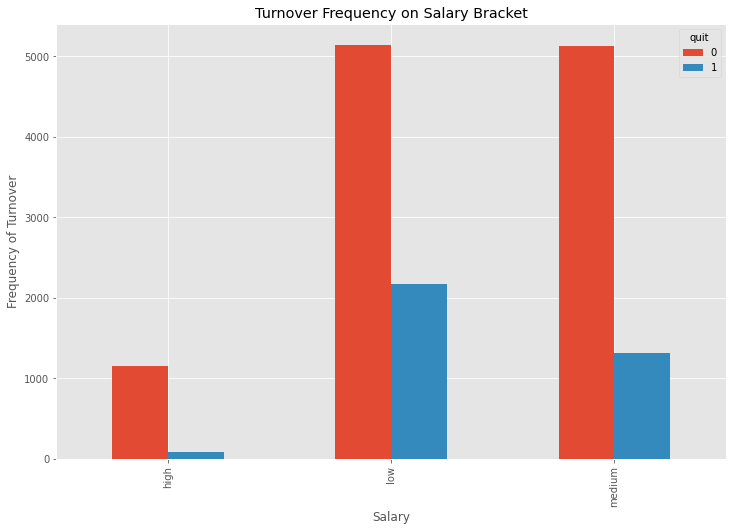

In [8]:
pd.crosstab(hr.salary, hr.quit).plot(kind="bar")
plt.title("Turnover Frequency on Salary Bracket")
plt.xlabel("Salary")
plt.ylabel("Frequency of Turnover")
plt.show()

### Task 3: Encode Categorical Features
---

In [9]:
cat_vars = ['department', 'salary']
for var in cat_vars:
    cat_list = pd.get_dummies(hr[var], prefix=var)
    hr = hr.join(cat_list)

In [10]:
hr.head()

,satisfaction_level,last_evaluation,number_project,average_montly_hours,time_spend_company,Work_accident,quit,promotion_last_5years,department,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical,salary_high,salary_low,salary_medium
0,0.38,0.53,2,157,3,0,1,0,sales,low,0,0,0,0,0,0,0,1,0,0,0,1,0
1,0.80,0.86,5,262,6,0,1,0,sales,medium,0,0,0,0,0,0,0,1,0,0,0,0,1
2,0.11,0.88,7,272,4,0,1,0,sales,medium,0,0,0,0,0,0,0,1,0,0,0,0,1
3,0.72,0.87,5,223,5,0,1,0,sales,low,0,0,0,0,0,0,0,1,0,0,0,1,0
4,0.37,0.52,2,159,3,0,1,0,sales,low,0,0,0,0,0,0,0,1,0,0,0,1,0


In [11]:
hr.drop(columns = ['department', 'salary'], axis = 1, inplace = True)

### Task 4: Visualize Class Imbalance
---

In [51]:
from yellowbrick.target import ClassBalance
plt.style.use("ggplot")
plt.rcParams['figure.figsize'] = (12,8)

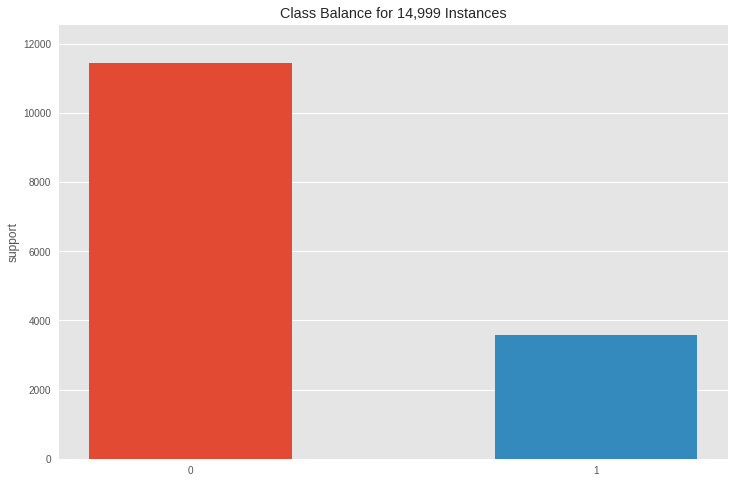

In [97]:
fig=plt.figure()
ax=fig.add_subplot()
visualizer = ClassBalance(ax=ax)
visualizer.fit(hr.quit)
visualizer.poof()

### Task 5: Create Training and Test Sets
---

In [24]:
X = hr.loc[:, hr.columns != 'quit']
y = hr.quit

In [25]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size = 0.2, stratify = y)

### Task 6 & 7: Build an Interactive Decision Tree Classifier
---

Supervised learning: 
- The inputs are random variables $X = X_1, ..., X_p$;
- The output is a random variable $Y.$

- Data is a finite set $$\mathbb{L}=\{(x_i,y_i)|i=0, ..., N-1\}$$
where $x_i \in X = X_1 \times ... \times X_p$ and $y_i \in y$ are randomly drawn from $P_{X,Y}.$

E.g., $(x_i,y_i)=((\text{salary = low, department = sales, ...}),\text{quit = 1})$

- The goal is to find a model $\varphi_\mathbb{L}: X \mapsto y$ minimizing $$\text{Err}(\varphi_\mathbb{L}) = \mathbb{E}_{X,Y}\{L(Y, \varphi_\mathbb{L}(X))\}.$$

About:
 
 - Decision trees are non-parametric models which can model arbitrarily complex relations between inputs and outputs, without any a priori assumption
 
- Decision trees handle numeric and categorical variables

- They implement feature selection, making them robust to noisy features (to an extent)

- Robust to outliers or errors in labels

- Easily interpretable by even non-ML practioners.

#### Decision trees: partitioning the feature space:

![partition](assets/images/partition-feature-space.png)

- Decision trees generally have low bias but have high variance.
- We will solve the high variance problem in Task 8.

In [26]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.tree import export_graphviz # display the tree within a Jupyter notebook
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
from ipywidgets import interactive, IntSlider, FloatSlider, interact
import ipywidgets
from IPython.display import Image
from subprocess import call
import matplotlib.image as mpimg

In [70]:
@interact
def plot_tree(crit=['gini', 'entropy'],
              split=['best', 'random'],
              depth=IntSlider(min=1,max=30,value=2, continuous_update=False),
              min_split=IntSlider(min=2,max=5,value=2, continuous_update=False),
              min_leaf=IntSlider(min=1,max=5,value=1, continuous_update=False)):
    estimator=DecisionTreeClassifier(random_state=0,
                                     criterion=crit,
                                     splitter=split,
                                     max_depth=depth,
                                     min_samples_split=min_split,
                                     min_samples_leaf=min_leaf)
    estimator.fit(X_train, y_train)
    print('Decision Tree Training Accuracy: {:.3f}'.format(accuracy_score(y_train, estimator.predict(X_train))))
    print('Decision Tree Test Accuracy: {:.3f}'.format(accuracy_score(y_test, estimator.predict(X_test))))
    graph = Source(tree.export_graphviz(estimator, out_file=None,
                                        feature_names=X_train.columns,
                                        class_names=['stayed', 'quit'],
                                        filled=True))
    display(Image(data=graph.pipe(format='png')))
    return estimator

interactive(children=(Dropdown(description='crit', options=('gini', 'entropy'), value='gini'), Dropdown(descri…

### Task 8: Build an Interactive Random Forest Classifier
---

Although randomization increases bias, it is possible to get a reduction in variance of the ensemble. Random forests are one of the most robust machine learning algorithms for a variety of problems.

- Randomization and averaging lead to a reduction in variance and improve accuracy
- The implementations are parallelizable
- Memory consumption and training time can be reduced by bootstrapping
- Sampling features and not solely sampling examples is crucial to improving accuracy

In [71]:
@interact
def plot_tree_rf(crit=['gini', 'entropy'],
                 bootstrap=['True', 'False'],
                 depth=IntSlider(min=1,max=30,value=3, continuous_update=False),
                 forests=IntSlider(min=1,max=200,value=100,continuous_update=False),
                 min_split=IntSlider(min=2,max=5,value=2, continuous_update=False),
                 min_leaf=IntSlider(min=1,max=5,value=1, continuous_update=False)):
    estimator = RandomForestClassifier(random_state=1,
                                       criterion=crit,
                                       bootstrap=bootstrap,
                                       n_estimators=forests,
                                       max_depth=depth,
                                       min_samples_split=min_split,
                                       min_samples_leaf=min_leaf,
                                       n_jobs=-1,
                                       verbose=False)
    estimator.fit(X_train, y_train)
    
    print('Random Forest Training Accuracy: {:.3f}'.format(accuracy_score(y_train, estimator.predict(X_train))))
    print('Random Forest Test Accuracy: {:.3f}'.format(accuracy_score(y_test, estimator.predict(X_test))))
    num_tree = estimator.estimators_[0]
    print('\Visualizing Tree', 0)
    graph = Source(tree.export_graphviz(num_tree, out_file=None,
                                        feature_names=X_train.columns,
                                        class_names=['stayed', 'quit'],
                                        filled=True))
    display(Image(data=graph.pipe(format='png'))) 
    return estimator

interactive(children=(Dropdown(description='crit', options=('gini', 'entropy'), value='gini'), Dropdown(descri…

### Task 9: Feature Importance and Evaluation Metrics
---

In [89]:
from yellowbrick.features import FeatureImportances
plt.rcParams['figure.figsize'] = (12,8)
plt.style.use("ggplot")


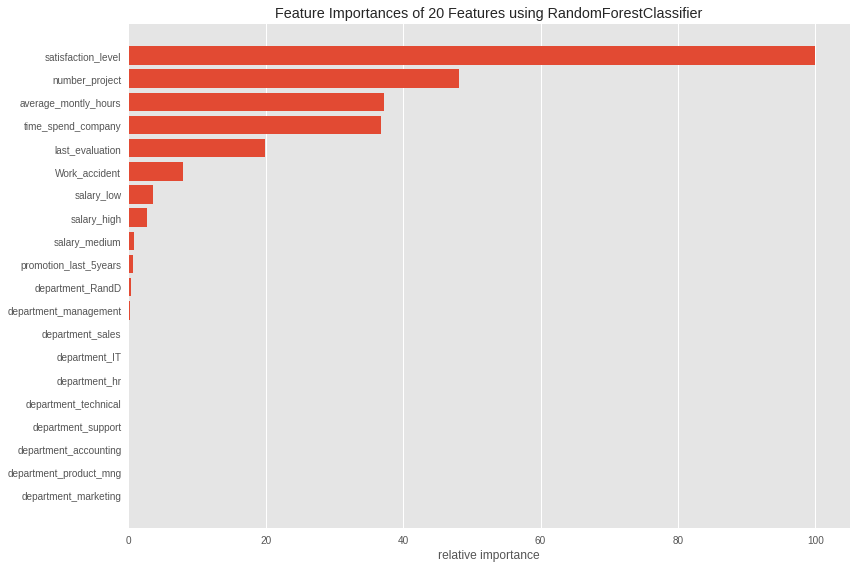

In [90]:
fig = plt.figure()
ax = fig.add_subplot()
rf = RandomForestClassifier(bootstrap='True', ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=3, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=-1, oob_score=False, random_state=1,
                       verbose=False, warm_start=False)
viz = FeatureImportances(rf, ax=ax)
viz.fit(X_train, y_train)
viz.poof()

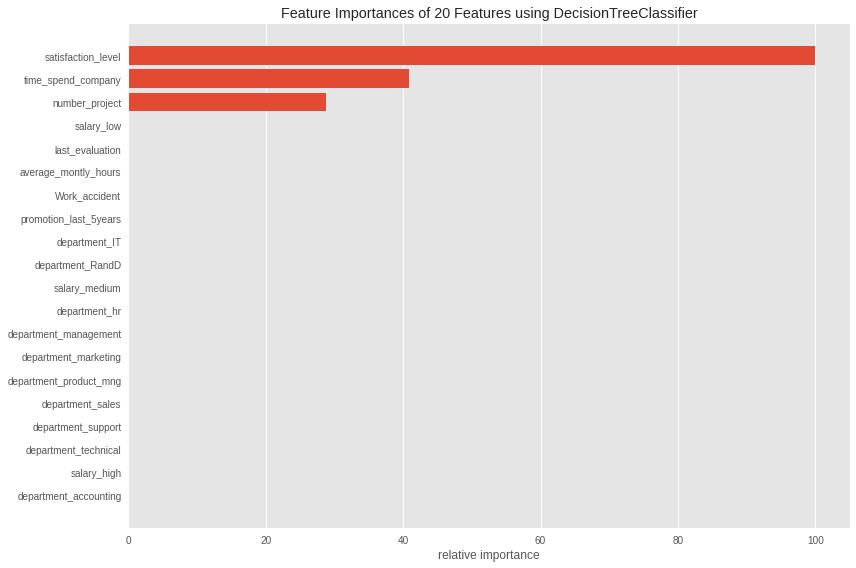

In [91]:
fig = plt.figure()
ax = fig.add_subplot()
dt = DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')

viz = FeatureImportances(dt, ax=ax)
viz.fit(X_train, y_train)
viz.poof()

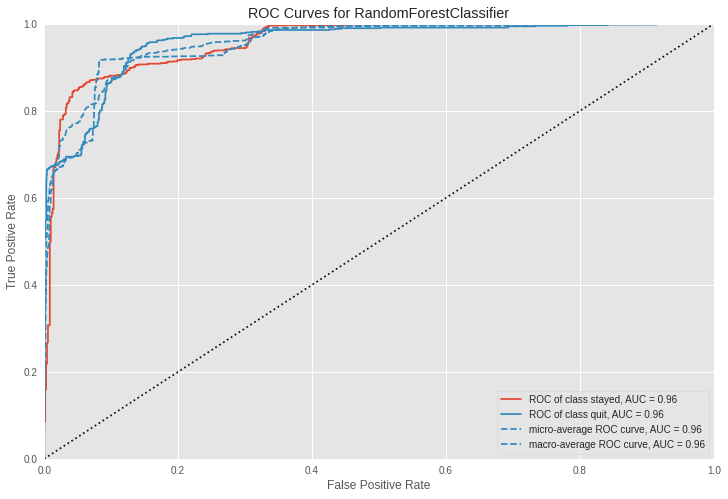

In [86]:
from yellowbrick.classifier import ROCAUC

visualizer = ROCAUC(rf, classes=["stayed", "quit"])
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof()

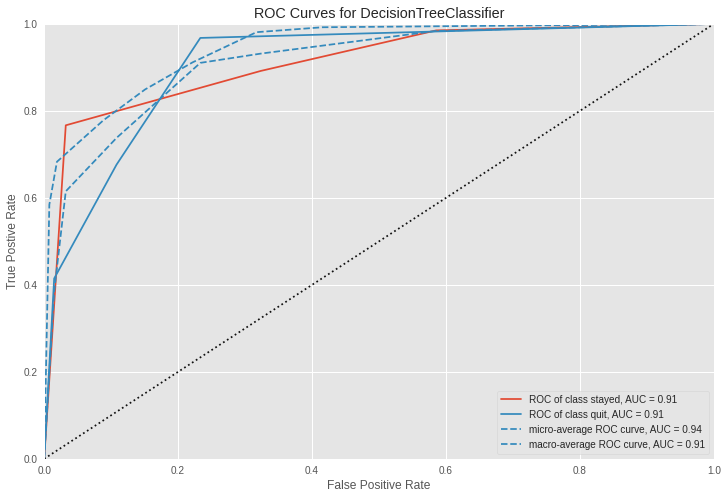

In [87]:
visualizer = ROCAUC(dt, classes=["stayed", "quit"])
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.poof()

Random Forest perform much better than Decision Tree in this example.